In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.special import logsumexp

from scipy.special import logsumexp
from scipy.signal import correlate
from statsmodels.tsa.stattools import acf
import morphZ
import corner

In [2]:

def log_plus(x,y):
    
    if x > y:
      summ = x + np.log(1+np.exp(y-x))
    else:
        summ = y + np.log(1+np.exp(x-y))
    return summ

def log_sum(vec): 
    r = -np.Inf
    for i in range(len(vec)):
       #print('element:',vec[i])
       r =log_plus(r, vec[i])
       #print(r)
    return r



In [3]:

def lnlikefn(x):
        u = 0.01
        v = 0.1
        x1 = np.sum(-(x**2)/(2*v**2))-len(x)*np.log(np.sqrt(2*np.pi)*v)
        #print(x1)
        x2 = np.sum(-((x-0)**2)/(2*u**2))-len(x)*np.log(np.sqrt(2*np.pi)*u)#+np.log(100)
        #print(x2)
        return log_plus(x1,x2)

def lnpriorfn(x):

    if np.any((x < -0.5) | (x > 0.5)):  # Check if x is outside the cube
        return -np.inf 

    return 0.0 

def lnprobfn(x):
    return lnlikefn(x) + lnpriorfn(x)



In [4]:
import numpy as np
import dynesty
from dynesty import utils as dyfunc

ndim = 20  # number of parameters/dimensions
# nlive = 20 * ndim  # number of live points (analogous to nwalkers)
nlive = 20 * ndim  # number of live points (analogous to nwalkers)



# Define the prior transform: maps a unit cube (0,1) to the prior volume.
# For a uniform prior between -0.5 and 0.5 for each parameter:
def prior_transform(u):
    # u is a 1D array of ndim values in [0, 1]
    return -0.5 + u  # scales u to [-0.5, 0.5]

# Create the nested sampler instance.

# Run the nested sampling.
# Note: print_progress=True shows the progress.
NN = 1

log_z_NS = np.zeros(NN)
log_z_NS_err = np.zeros(NN)

for i in range(NN):
    sampler = dynesty.NestedSampler(lnlikefn, prior_transform, ndim, nlive=nlive)
    sampler.run_nested(dlogz=0.000000001, maxiter=2000000,print_progress=True)
    res = sampler.results
    log_z_NS[i] = res.logz[-1]
    log_z_NS_err[i] = res.logzerr[-1]


# Get posterior samples.
# dynesty provides weighted samples; here we compute equal-weight samples.
samples_ns, weights = res.samples, np.exp(res.logwt - res.logz[-1])
posterior_samples = dyfunc.resample_equal(samples_ns, weights)



37369it [00:50, 736.61it/s, +400 | bound: 605 | nc: 1 | ncall: 1452205 | eff(%):  2.602 | loglstar:   -inf < 73.419 <    inf | logz:  0.837 +/-  0.331 | dlogz:  0.000 >  0.000]


Posterior samples shape: (37769, 20)
NS log(z): 0.8371848036116617 +/- 0.33082098771501706


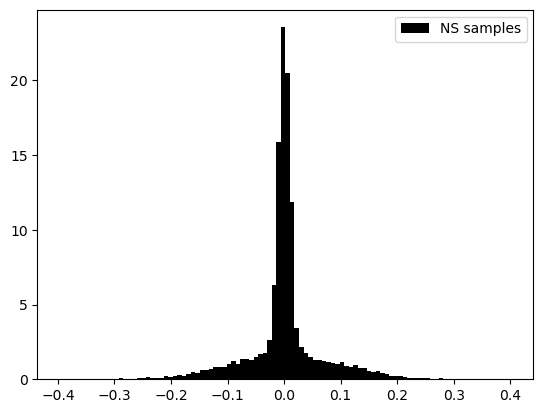

In [5]:
print("Posterior samples shape:", posterior_samples.shape)
plt.hist(posterior_samples[:,4],color='black',density=True ,bins=100,label='NS samples')
# plt.hist(samples[:,4],color='red',density=True ,bins=100,alpha=0.5,label='thinned samples')
# plt.hist(tree_samples[:,2],color='blue',density=True ,bins=100,alpha=0.5,label='tree samples')

plt.legend()
print(f'NS log(z): {res.logz[-1]} +/- {res.logzerr[-1]}')


In [6]:
# import logging
# from morphZ import setup_logging; setup_logging(level=logging.INFO)
samples = posterior_samples[::50,:]  # total_samples[::20,:]
tot_len , ndim = samples.shape
print('Total samples:', tot_len, 'Dimensions:', ndim)
log_prob = np.zeros(tot_len)

for i in range(tot_len):
    log_prob[i] = lnprobfn(samples[i,:])

log_p_estimate = morphZ.evidence(
samples,
log_prob,
lnprobfn,
n_resamples=2000,
thin=1,n_estimations=2,morph_type="pair",kde_bw="scott",plot=True,output_path='./morphZ_peak_sampling_new')
#print('True:', np.log(2))
print('True for 1 amp peak:', np.log(2))


Total samples: 756 Dimensions: 20


Filtered proposal samples: 2000 valid samples out of 2000 total samples.
Estimation 1/2
iteration: 4 log(z) old: 0.4533549316786374 log(z) New: 0.45326012587926234
Converged in 4 iterations. log(z): 0.4534 +/-: 0.2735

Filtered proposal samples: 2000 valid samples out of 2000 total samples.
Estimation 2/2
iteration: 3 log(z) old: 0.49019511026032747 log(z) New: 0.4901774229038063
Converged in 3 iterations. log(z): 0.4902 +/-: 0.2795

Saved log(z) to ./morphZ_peak_sampling_new/logz_morph_z_pair_scott.txt
True for 1 amp peak: 0.6931471805599453


In [7]:
plt.hist(posterior_samples[::1,0],density=True,bins=30,)
plt.hist(posterior_samples[::5,0],density=True,bins=30,alpha=0.5)
plt.hist(posterior_samples[::100,0],density=True,bins=30,alpha=0.3)



(array([ 0.17253399,  0.34506799,  0.17253399,  0.17253399,  1.03520396,
         0.69013598,  1.38027195,  0.        ,  0.51760198,  1.03520396,
         1.89787393,  1.55280595,  7.41896174, 21.22168127, 14.14778751,
         2.9330779 ,  1.38027195,  2.24294192,  1.20773796,  0.86266997,
         1.03520396,  0.86266997,  0.69013598,  0.17253399,  0.69013598,
         0.        ,  0.34506799,  0.51760198,  0.17253399,  0.34506799]),
 array([-0.20955052, -0.19421729, -0.17888407, -0.16355084, -0.14821762,
        -0.13288439, -0.11755117, -0.10221794, -0.08688471, -0.07155149,
        -0.05621826, -0.04088504, -0.02555181, -0.01021859,  0.00511464,
         0.02044786,  0.03578109,  0.05111432,  0.06644754,  0.08178077,
         0.09711399,  0.11244722,  0.12778044,  0.14311367,  0.15844689,
         0.17378012,  0.18911335,  0.20444657,  0.2197798 ,  0.23511302,
         0.25044625]),
 <BarContainer object of 30 artists>)

In [8]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

log_p_estimate = np.array(log_p_estimate)
true_z = np.log(2)
plt.hlines(y=true_z,colors='grey',linestyle='dotted',xmin=0.5, xmax=5.5,label='True log(z)')

x1= [1,2,3,4]
#median = [np.mean(z_GSS_mcmc),res.logz[-1],np.mean(log_p_estimate)]
#error = [np.std(z_GSS_mcmc),res.logzerr[-1],np.std(log_p_estimate)]
median = [np.mean(log_z_NS),np.mean(log_z_NS),np.mean(log_p_estimate[:,0]),np.mean(log_p_estimate[:,0])]
error = [np.mean(log_z_NS),np.mean(log_z_NS_err),np.std(log_p_estimate[:,0]),np.mean(log_p_estimate[:,1])]
ax.errorbar(x1, median, yerr=error, fmt='+', color='black', capsize=5)


ax.set_xticks(x1,labels=[r'NS$_{Emp}$',r'NS$_{Theo}$', r'Morph$_{Emp}$',r'Morph$_{RMSE}$'],fontsize=10)
ax.set_ylabel('log(z)')
ax.legend()

In [9]:

# for row in total_samples: 
#     np.random.shuffle(row)
    
samples = posterior_samples[::5,:]  # total_samples[::20,:]
tot_len , ndim = samples.shape
log_prob = np.zeros(tot_len)

for i in range(tot_len):
    log_prob[i] = lnprobfn(samples[i,:])


print(f'Ncal {tot_len} Ndim {ndim}, log prob {len(log_prob)}')
N_new = 10000
target_kde = KDE_approx(samples[:int(tot_len/2),:])

NN = 25
log_p_estimate = np.zeros((NN,3))
samples_mor = samples[int(tot_len/2):,:]
log_post = log_prob[int(tot_len/2):]
print(samples_mor.shape)

for gg in range(NN):
    print(f"Iteration : {gg+1}\n",end="")
    samples_prop = target_kde.resample(N_new)
    log_prop = target_kde.logpdf_kde(samples_prop)

    log_p_estimate[gg,:] , log_z = bridge_sampling_ln(lnprobfn, target_kde.logpdf_kde, samples_mor,log_post, samples_prop)

print(f'\n true:{np.log(2)}' )

Ncal 7554 Ndim 20, log prob 7554


NameError: name 'KDE_approx' is not defined